In [1]:
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
import argparse
from sklearn import metrics
from tqdm.notebook import tqdm
import gc
import shutil 

In [2]:
labels = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased']

# labels = ['Fp1','Fp2','F7','F3','Fz','F4']

In [3]:
torch.manual_seed(2021)
np.random.seed(2021)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=1024, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.002, help="adam's learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.99, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=1, help="number of cpu threads to use during batch generation")
parser.add_argument("--in_len", type=int, default=2**10, help="length of the input fed to neural net")
parser.add_argument("--in_channels", type=int, default=32, help="number of signal channels")
parser.add_argument("--out_channels", type=int, default=6, help="number of classes")
parser.add_argument("--chunk", type=int, default=1000, help="length of splited chunks")
opt, unknown = parser.parse_known_args()
print(device)

cpu


In [4]:
%%time
def read_csv(data, events):
    x = pd.read_csv(data)
    y = pd.read_csv(events)
    id = '_'.join(x.iloc[0, 0].split('_')[:-1])
    x = x.iloc[:,1:].values
    y = y.iloc[:,1:].values
    return x, y
    
path="/Users/alainamahalanabis/Documents/EHR_GAN"
trainset = []
gt = []
for filename in tqdm(os.listdir(f'{path}/train')):
    if 'data' in filename:
        data_file_name = os.path.join(f'{path}/train', filename)
        id = filename.split('.')[0]
        events_file_name = os.path.join(f'{path}/train', '_'.join(id.split('_')[:-1]) + '_events.csv')
#         print(data_file_name)
        x, y = read_csv(data_file_name, events_file_name)
        trainset.append(x.T.astype(np.float32))
        gt.append(y.T.astype(np.float32))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alainamahalanabis/Documents/EHR_GAN/train'

In [8]:
valid_dataset = trainset[-2:]
valid_gt = gt[-2:]
trainset = trainset[:-2]
gt = gt[:-2]


In [9]:
def resample_data(gt, chunk_size=opt.chunk):
    """
    split long signals to smaller chunks, discard no-events chunks  
    """
    total_discard_chunks = 0
    mean_val = []
    threshold = 0.01
    index = []
    
    for i in range(len(gt)):
        for j in range(0, gt[i].shape[1], chunk_size):
            mean_val.append(np.mean(gt[i][:, j:min(gt[i].shape[1],j+chunk_size)]))
            if mean_val[-1] < threshold:  # discard chunks with low events time
                total_discard_chunks += 1
            else:
                index.extend([(i, k) for k in range(j, min(gt[i].shape[1],j+chunk_size))])

    plt.plot([0, len(mean_val)], [threshold, threshold], color='r')
    plt.scatter(range(len(mean_val)), mean_val, s=1)
    plt.show()
    print('Total number of chunks discarded: {} chunks'.format(total_discard_chunks))
    print('{}% data'.format(total_discard_chunks/len(mean_val)))
    del mean_val
    gc.collect()
    return index

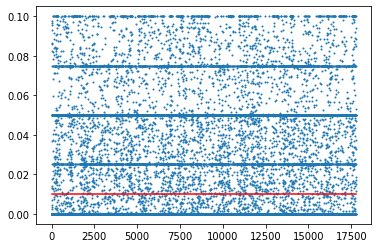

Total number of chunks discarded: 8862 chunks
0.4987337497889583% data
length :  8907000
CPU times: user 1.91 s, sys: 312 ms, total: 2.22 s
Wall time: 2.23 s


In [10]:
%%time
class EEGSignalDataset(Dataset):
    def __init__(self, data, gt,  soft_label=True, train=True):
        self.data = data
        self.gt = gt
        self.train = train
        self.soft_label = soft_label
        self.eps = 1e-7
        if train:
            self.index = resample_data(gt)
        else:
            self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]
#         for dt in self.data:
#             dt -= m
#             dt /= s+self.eps
    
    def __getitem__(self, i):
        i, j = self.index[i]
        raw_data, label = self.data[i][:,max(0, j-opt.in_len+1):j+1], \
                self.gt[i][:,j]
        
        pad = opt.in_len - raw_data.shape[1]
        if pad:
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)

        raw_data, label = torch.from_numpy(raw_data.astype(np.float32)),\
                            torch.from_numpy(label.astype(np.float32))
        if self.soft_label:
            label[label < .02] = .02
        return raw_data, label
            
    
    def __len__(self):
        return len(self.index)
    

dataset = EEGSignalDataset(trainset, gt) 
dataloader = DataLoader(dataset, batch_size = opt.batch_size,\
                                       num_workers = opt.n_cpu, shuffle=True)

# trainset1=DataLoader(trainset,batch_size = opt.batch_size,\
#                                        num_workers = opt.n_cpu, shuffle=True)

print("length : ", len(dataset))

In [11]:
print(dataset)

In [12]:
eeg_data=[]
counter=0
for data in dataset:
  #print("Data: ", data)
  counter+=1
  if counter < 5:
   eeg_data.append(data)
  else :
   break

In [13]:
print(eeg_data[0][0])

tensor([[   0.,    0.,    0.,  ..., -570., -599., -607.],
        [   0.,    0.,    0.,  ..., -705., -739., -733.],
        [   0.,    0.,    0.,  ..., -233., -269., -292.],
        ...,
        [   0.,    0.,    0.,  ..., -234., -313., -212.],
        [   0.,    0.,    0.,  ..., -337., -366., -328.],
        [   0.,    0.,    0.,  ..., -345., -457., -260.]])


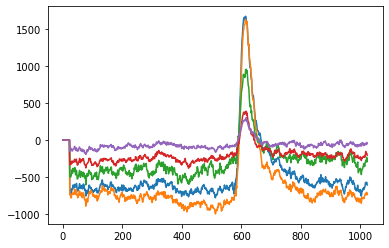

In [17]:
import matplotlib.pyplot as plt
#print(eeg_data[0][0][:5].numpy())

plt.figure()
plt.plot(eeg_data[0][0][:5].t().numpy())

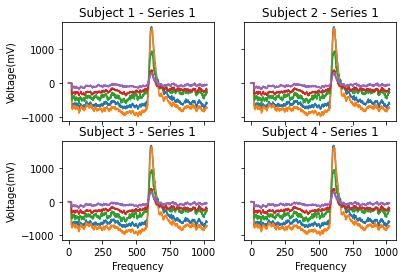

In [19]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(eeg_data[0][0][:5].t().numpy())
axs[0, 0].set_title('Subject 1 - Series 1')
axs[0, 1].plot(eeg_data[1][0][:5].t().numpy())
axs[0, 1].set_title('Subject 2 - Series 1')
axs[1, 0].plot(eeg_data[2][0][:5].t().numpy())
axs[1, 0].set_title('Subject 3 - Series 1')
axs[1, 1].plot(eeg_data[3][0][:5].t().numpy())
axs[1, 1].set_title('Subject 4 - Series 1')

for ax in axs.flat:
    ax.set(xlabel='Frequency', ylabel='Voltage(mV)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
